In [1]:
import numpy as np 
import pandas as pd 
from scipy.stats import randint
from sklearn import tree
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

In [45]:
data = pd.read_csv('socialdemo_input.csv')
data = data.dropna()
data = data[data['HH_INC_group']>=0]
data = data[data['R_AGE_group']>=0]
data.loc[data['WORKER']==-9,'WORKER']= 0
data.loc[data['WORKER']==-1,'WORKER']= 0
data.loc[data['WKFTPT']==-8,'WKFTPT']= 0
data.loc[data['WKFTPT']==-7,'WKFTPT']= 0
data.loc[data['WKFTPT']==-1,'WKFTPT']= 0

HH_INC_group  
R_AGE_group

### train a decision tree

In [46]:
target = data[['HH_INC_group']] # or [['R_AGE_group']]
features = data[['CNTTDTR','HBHUR','MSACAT','MSASIZE','RAIL',
                 'URBAN','URBANSIZE','URBRUR',
                 'USEPUBTR','WKFTPT','WORKER',
                 'cbg_income_pct_less_50k','cbg_income_pct_50k_100k', 'cbg_income_pct_100k_more',
                 'cbg_age_pct_under_17', 'cbg_age_pct_18_34', 'cbg_age_pct_35_64', 'cbg_age_pct_65_over',
                 'ct_poverty_rate', 'ct_edu_pct_less_HS', 'ct_edu_pct_SCND_AD', 'ct_edu_pct_BD_more', 
                 'PUBUSE', 'Nighttrip','Morningtrip','earliesttrip','latesttrip']]

X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.3,random_state=5)

In [47]:
# Randomized search on hyper parameters
param_dist = {"max_depth": [3,4,5,6,7,8,9,10,11, None],
              "max_features": randint(1, 14),
              "min_samples_leaf": randint(1, 20),
              "min_samples_split": randint(2, 10),
              "criterion": ["gini", "entropy"],
              "class_weight": ["balanced"]}
clf = DecisionTreeClassifier()
clf_random = RandomizedSearchCV(estimator = clf, 
                                param_distributions = param_dist, 
                                n_iter = 100, cv = 10, 
                                verbose = 2, random_state=20, n_jobs = 10,
                                pre_dispatch = '2*n_jobs')
clf_random = clf_random.fit(X_train,y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   21.4s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   54.5s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed:  2.8min finished


In [ ]:
# select the best estimator
best_random = clf_random.best_estimator_
y_pred = best_random.predict(X_test) 
conf_mat = confusion_matrix(y_test, y_pred)

In [ ]:
print ("Accuracy : ", accuracy_score(y_test,y_pred)*100) 
print(best_random.max_depth,best_random.max_features,best_random.min_samples_leaf,
      best_random.min_samples_split,best_random.criterion,best_random.class_weight)
print(conf_mat)

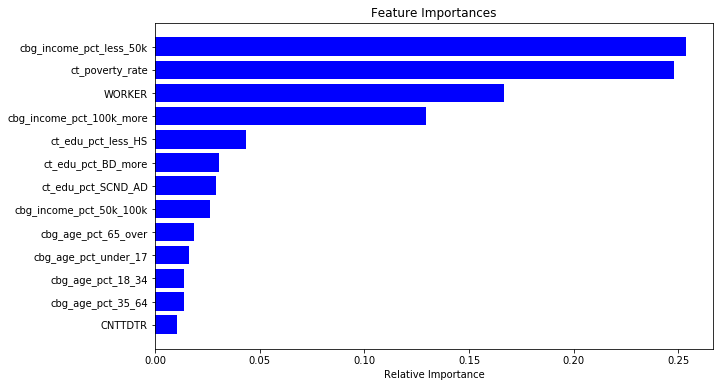

In [61]:
#plot feature importance
cols = features.columns.tolist()
importances = best_random.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,6))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [cols[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
#plot the tree
tree.plot_tree(best_random) 

In [ ]:
#save the model
import pickle
filename = 'D:/Project/Next Gen/Socialdemo/income_model.sav'
pickle.dump(best_random, open(filename, 'wb'))